### Import All Necessary Libraries
  - Make sure all libraries is downloaded in the machine or virtual enviroment.
  - run <code>pip install -r requirements.txt</code> to download everything

In [ ]:
import pandas as pd
import joblib
import json
import nltk
import time
from nltk.stem import WordNetLemmatizer
from nltk.data import find
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np

### Load datasets
- Load dataset downloaded online and custom dataset, then concatenate them into a single dataframe

In [2]:
df1 = pd.read_csv('data/bitext-hospitality-llm-chatbot-training-dataset.csv')
df2 = pd.read_csv('data/custom-dataset.csv')
df = pd.concat([df1, df2], ignore_index=True)
print(f"Total records: {len(df)}")

Total records: 32000


### Download NLTK resources
Check if the resources exist, if no, download them.
Stored in <code>C:/Users/{username}/AppData/Roaming/nltk_data/</code>

In [3]:
def safe_nltk_download(resource):
    try:
        find(resource)
    except LookupError:
        nltk.download(resource.split('/')[-1])

safe_nltk_download('corpora/wordnet')
safe_nltk_download('corpora/omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data preparation

In [ ]:
# convert to lowercase
df['instruction'] = df['instruction'].str.lower()
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)
# vectorise: text -> numerical vector
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.9
)
X = vectorizer.fi


t_transform(df['instruction'])
y = df['intent']
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['instruction'] = df['instruction'].apply(
    lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split())
)

### Data training with logistic regression algorithm
Train-test split: 80% train, 20% test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CalibratedClassifierCV(
    base_estimator=LogisticRegression(max_iter=1000,
                            solver='lbfgs',
                            C=3.0,
                            penalty='l2'),
    method='softmax'
)

model.fit(X_train, y_train)
print("Training completed.")

Training completed.


### Model evaluation

Accuracy: 0.9428125

Classification Report:

                          precision    recall  f1-score   support

               add_night       0.98      0.98      0.98       244
              book_hotel       0.91      0.91      0.91       217
      book_parking_space       1.00      0.98      0.99       238
              bring_pets       1.00      0.99      0.99       242
cancel_hotel_reservation       1.00      0.96      0.98       222
       cancellation_fees       1.00      1.00      1.00       266
change_hotel_reservation       0.99      0.95      0.97       221
      check_child_policy       0.91      0.83      0.87        36
         check_functions       0.89      0.89      0.89        44
  check_hotel_facilities       0.98      0.94      0.96       227
      check_hotel_offers       0.99      0.97      0.98       258
      check_hotel_prices       0.98      0.94      0.96       238
 check_hotel_reservation       0.81      0.77      0.79       255
                check_in      

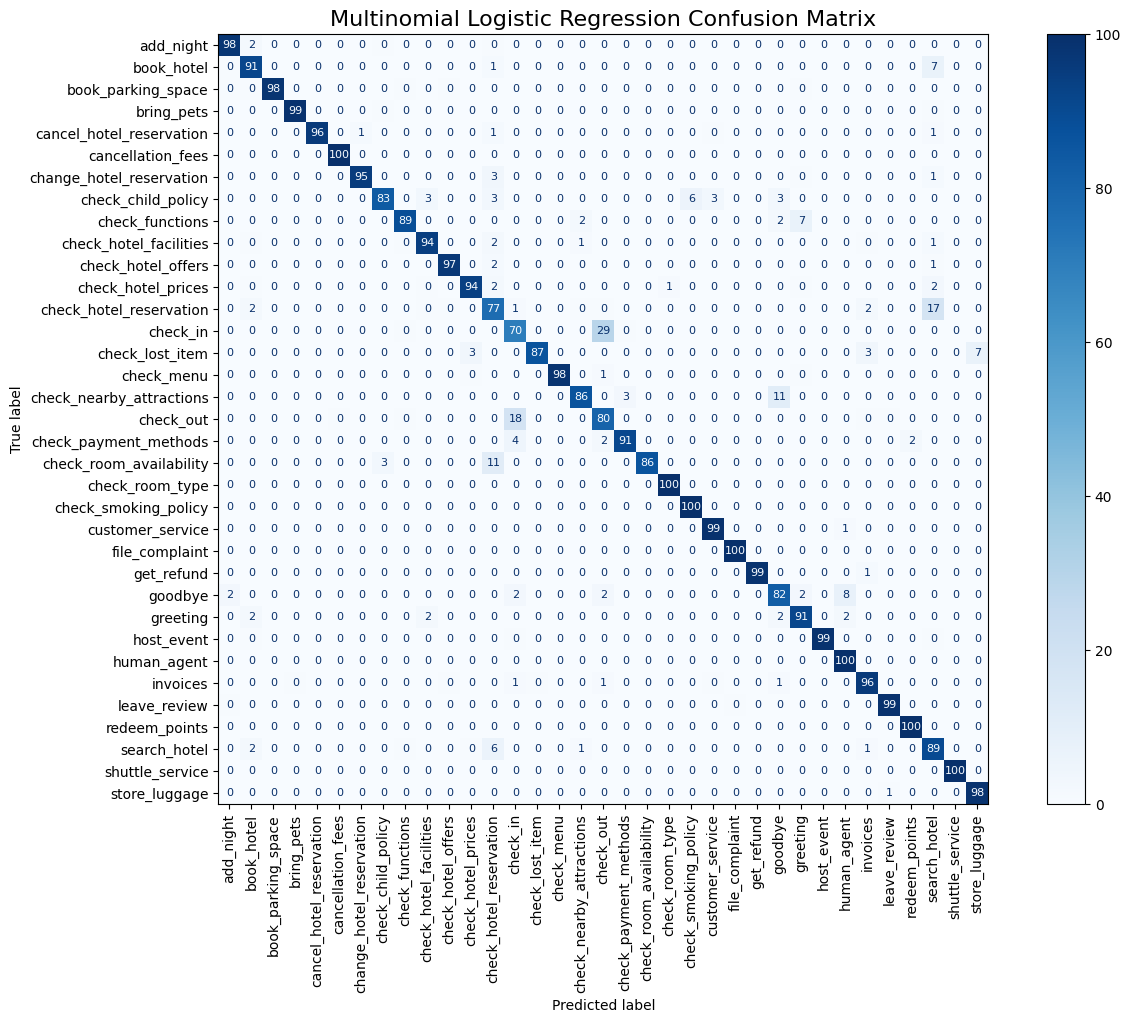

In [6]:
pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n")
print(classification_report(y_test, pred, zero_division=0))

cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(15, 10))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    pred,
    display_labels=model.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
    xticks_rotation="vertical",
    text_kw={'fontsize': 8},
    ax=ax
)

# ---- FORMAT DECIMALS HERE ----
for t in disp.text_.ravel():
    val = float(t.get_text())
    t.set_text(f"{val*100:.0f}")   # ← 0 decimals (e.g., 95). Use .1f for 95.3 etc.

# ---- Format colorbar (legend) ----
cbar = disp.im_.colorbar
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t*100:.0f}" for t in ticks])  # convert to whole numbers

plt.title("Multinomial Logistic Regression Confusion Matrix", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


### Learning Curve

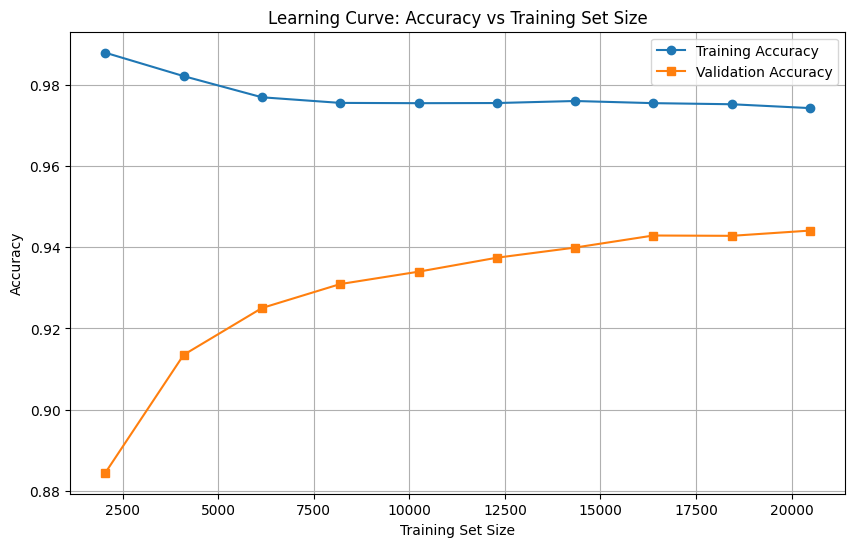

In [7]:
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% data
    n_jobs=-1
)

# Mean scores
train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy')
plt.plot(train_sizes, test_mean, marker='s', label='Validation Accuracy')

plt.title("Learning Curve: Accuracy vs Training Set Size")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

### Save model and vectorizer

In [8]:
print("Saving model...")
joblib.dump(model, "joblib/intent_model.joblib")
joblib.dump(vectorizer, "joblib/intent_vectorizer.joblib")
print("Saved.")


Saving model...
Saved.


# Chat loop

In [9]:
#! Load model + vectorizer
try:
    model = joblib.load("joblib/intent_model.joblib")
    vectorizer = joblib.load("joblib/intent_vectorizer.joblib")
except FileNotFoundError:
    print("Model or vectorizer file not found.")

#! Load json 
try:
    with open("response/responses.json", "r") as f:
        responses = json.load(f)
except FileNotFoundError:
    print("Responses file not found.")
    
try:
    with open("response/hotel-data.json", "r") as f:
        hotel_data = json.load(f)
except FileNotFoundError:
    print("Hotel data file not found.")

#! Chatbot reply function
def chatbot_reply(user_input):
    user_input = user_input.lower()
    start_time = time.time()
    vec = vectorizer.transform([user_input])
    intent = model.predict(vec)[0]
    proba = model.predict_proba(vec)[0]
    confidence = float(np.max(proba))
    response = responses.get(intent, "unknown_intent")
    
    if isinstance(response, list):
        response = response[0]
    elapsed = round((time.time() - start_time) * 1000, 2)
    try:
        # .format() auto-fills {placeholders} using data.json
        return {
        "intent": intent,
        "confidence": confidence,
        "response": response.format(**hotel_data),
        "time_ms": elapsed
    }
    except KeyError as e:
        # If a placeholder is missing in data.json, show error clearly
        return f"[Missing data for: {e.args[0]}]"


#! Main chat loop
print("Chatbot Interface")
print("Ask me about room prices, check-in times, or facilities!")
print("Type '>exit' to end the chat.\n")
prompt = ""
while True:
    prompt = input("Enter your message: ")
    if prompt.lower() != ">exit":
        reply = chatbot_reply(prompt)
        print(f"You: {prompt}")
        print(f"Bot: {reply['response']}\n"
              f"\t(Intent: {reply['intent']}, Confidence: {reply['confidence']*100:.2f}%, Time: {reply['time_ms']} ms)")
    else:
        break

print("\nChat ended.")


Chatbot Interface
Ask me about room prices, check-in times, or facilities!
Type '>exit' to end the chat.


Chat ended.
